# UTS Model Deployment

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score


from xgboost import XGBClassifier

## Read the Data

In [4]:
data = pd.read_csv("Data/Dataset_b_hotel.csv")
data

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0.0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0.0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0.0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0.0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0.0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0.0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0.0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0.0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0.0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


## Exploratory Data Analysis

### Features Description

- **Booking_ID** = Pengenal unik dari tiap pemesanan
- **no_of_adults** = Jumlah orang dewasa
- **no_of_children** = Jumlah anak kecil
- **no_of_weekend_nights** = Jumlah malam akhir pekan (Sabtu atau Minggu) tamu menginap atau memesan untuk menginap di hotel
- **no_of_week_nights** = Jumlah malam dalam seminggu (Senin hingga Jumat) tamu menginap atau memesan untuk menginap di hotel
- **type_of_meal_plan** = Jenis paket makanan yang dipesan oleh pelanggan
- **required_car_parking_space** = Apakah pelanggan membutuhkan tempat parkir mobil? (0 - Tidak, 1- Ya)
- **room_type_reserved** = Jenis kamar yang dipesan oleh pelanggan. Nilai-nilai tersebut dienkripsi oleh INN Hotels
- **lead_time** = Jumlah hari antara tanggal pemesanan dan tanggal kedatangan
- **arrival_year** = Tahun tanggal kedatangan
- **arrival_month** = Bulan tanggal kedatangan
- **arrival_date** = Tanggal kedatangan
- **market_segment_type** = Penunjukan segmen pasar
- **repeated_guest** = Apakah pelanggan tersebut merupakan tamu yang pernah melakukan booking dan juga menginap? (0 - Tidak, 1- Ya)
- **no_of_previous_cancellations** = Jumlah pemesanan sebelumnya yang dibatalkan oleh pelanggan sebelum pemesanan saat ini
- **no_of_previous_bookings_not_canceled** = Jumlah pemesanan sebelumnya yang tidak dibatalkan oleh pelanggan sebelum pemesanan saat ini
- **avg_price_per_room** = Harga rata-rata per hari pemesanan; harga kamar bersifat dinamis. (dalam euro)
- **no_of_special_requests** = Jumlah total permintaan khusus yang dibuat oleh pelanggan (misalnya lantai yang tinggi, pemandangan dari kamar, dan lain-lain.)
- **booking_status** (target variable) = Flag yang menunjukkan apakah pemesanan dibatalkan atau tidak

### Check For Missing Values

In [5]:
count_missing = data.isna().sum()
percent_missing = data.isna().sum() * 100 / len(data)
missing_value_data = pd.DataFrame({'Count': count_missing, 'Percentage': round(percent_missing, 2)})
missing_value_data.sort_values('Count', ascending=False)

,Count,Percentage
avg_price_per_room,1632,4.5
required_car_parking_space,1270,3.5
type_of_meal_plan,907,2.5
no_of_children,0,0.0
no_of_adults,0,0.0
Booking_ID,0,0.0
no_of_week_nights,0,0.0
room_type_reserved,0,0.0
lead_time,0,0.0
arrival_year,0,0.0


There are several of missing value on the avg_price_per_room, required_car_parking_space, and type_of_meal_plan

### Check for Duplicates

In [6]:
print(data.duplicated().sum())

0


The dataset has no duplicates which is good

### Check the Datatype

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     35368 non-null  object 
 6   required_car_parking_space            35005 non-null  float64
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

### Check for Inconsistent Data

In [8]:
for col in data.columns:
    print(f"{col}: {data[col].nunique()}")

Booking_ID: 36275
no_of_adults: 5
no_of_children: 6
no_of_weekend_nights: 8
no_of_week_nights: 18
type_of_meal_plan: 4
required_car_parking_space: 2
room_type_reserved: 7
lead_time: 352
arrival_year: 2
arrival_month: 12
arrival_date: 31
market_segment_type: 5
repeated_guest: 2
no_of_previous_cancellations: 9
no_of_previous_bookings_not_canceled: 59
avg_price_per_room: 3850
no_of_special_requests: 6
booking_status: 2


In [9]:
for col in data.columns:
    unique_vals = data[col].unique()
    if len(unique_vals) < 60:
        sorted_unique = pd.Series(unique_vals).sort_values().tolist()
        print(f"{col:<40}: {sorted_unique}")

no_of_adults                            : [0, 1, 2, 3, 4]
no_of_children                          : [0, 1, 2, 3, 9, 10]
no_of_weekend_nights                    : [0, 1, 2, 3, 4, 5, 6, 7]
no_of_week_nights                       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
type_of_meal_plan                       : ['Meal Plan 1', 'Meal Plan 2', 'Meal Plan 3', 'Not Selected', nan]
required_car_parking_space              : [0.0, 1.0, nan]
room_type_reserved                      : ['Room_Type 1', 'Room_Type 2', 'Room_Type 3', 'Room_Type 4', 'Room_Type 5', 'Room_Type 6', 'Room_Type 7']
arrival_year                            : [2017, 2018]
arrival_month                           : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
arrival_date                            : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
market_segment_type                     : ['Aviation', 'Complementary', 'Corporate', 'Offline', 'O

### Data Visualization

#### Plot for Numerical Data

In [10]:
num_cols = ["lead_time", "avg_price_per_room"]
cat_cols = ["no_of_adults", "no_of_children", "no_of_week_nights", "type_of_meal_plan", "required_car_parking_space", "room_type_reserved", "arrival_year", "arrival_month", "arrival_date", "market_segment_type", "repeated_guest", "no_of_previous_cancellations", "no_of_previous_bookings_not_canceled", "no_of_special_requests", "booking_status"]

In [11]:
def num_plot(data):
    n = len(num_cols)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 3 * n))

    for i, col in enumerate(num_cols):
        sns.boxplot(x=data[col], ax=axes[i, 0])
        axes[i, 0].set_title(f'Boxplot of {col}')

        sns.histplot(data[col], kde=True, bins=30, ax=axes[i, 1])
        axes[i, 1].set_title(f'Histogram of {col}')

    fig.suptitle("Boxplot and Histogram of Numerical Columns", fontsize=20, y=1)
    plt.tight_layout()
    plt.show()

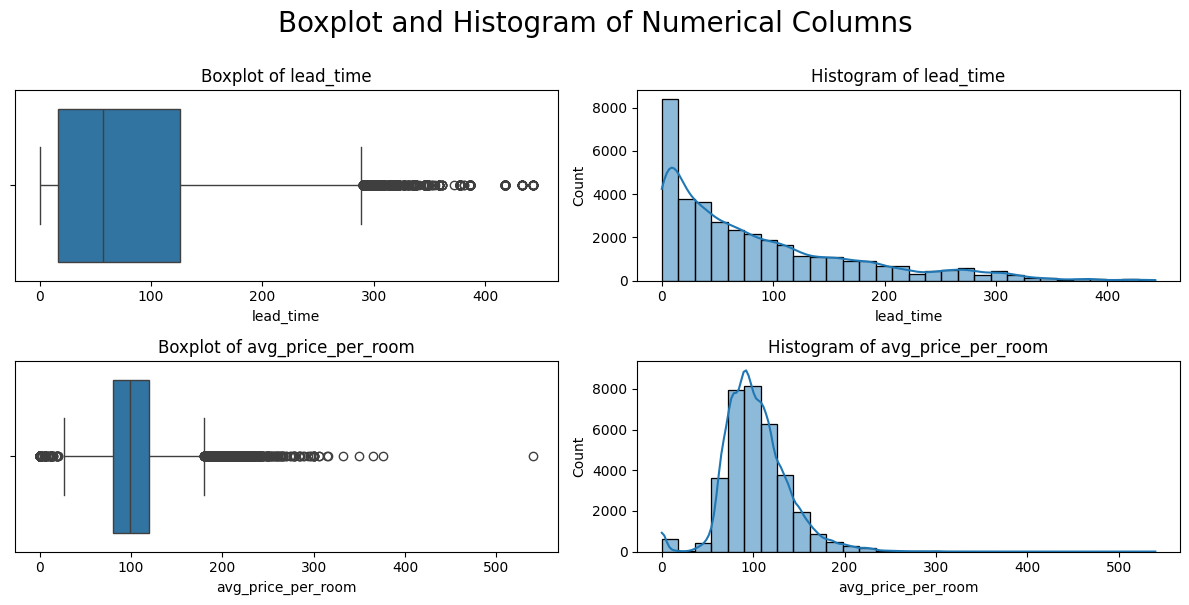

In [12]:
num_plot(data)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def cat_plot(data):
    n = len(cat_cols)
    fig, axes = plt.subplots(nrows=round(n / 2), ncols=2, figsize=(12, 2.5 * n))

    axes = axes.flatten()
    for i, col in enumerate(cat_cols):
        sns.countplot(data=data, x=col, ax=axes[i])
        axes[i].set_title(f'Barplot of {col}')

        for bar in axes[i].patches:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=9)

    fig.suptitle("Barplot of Categorical Columns", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

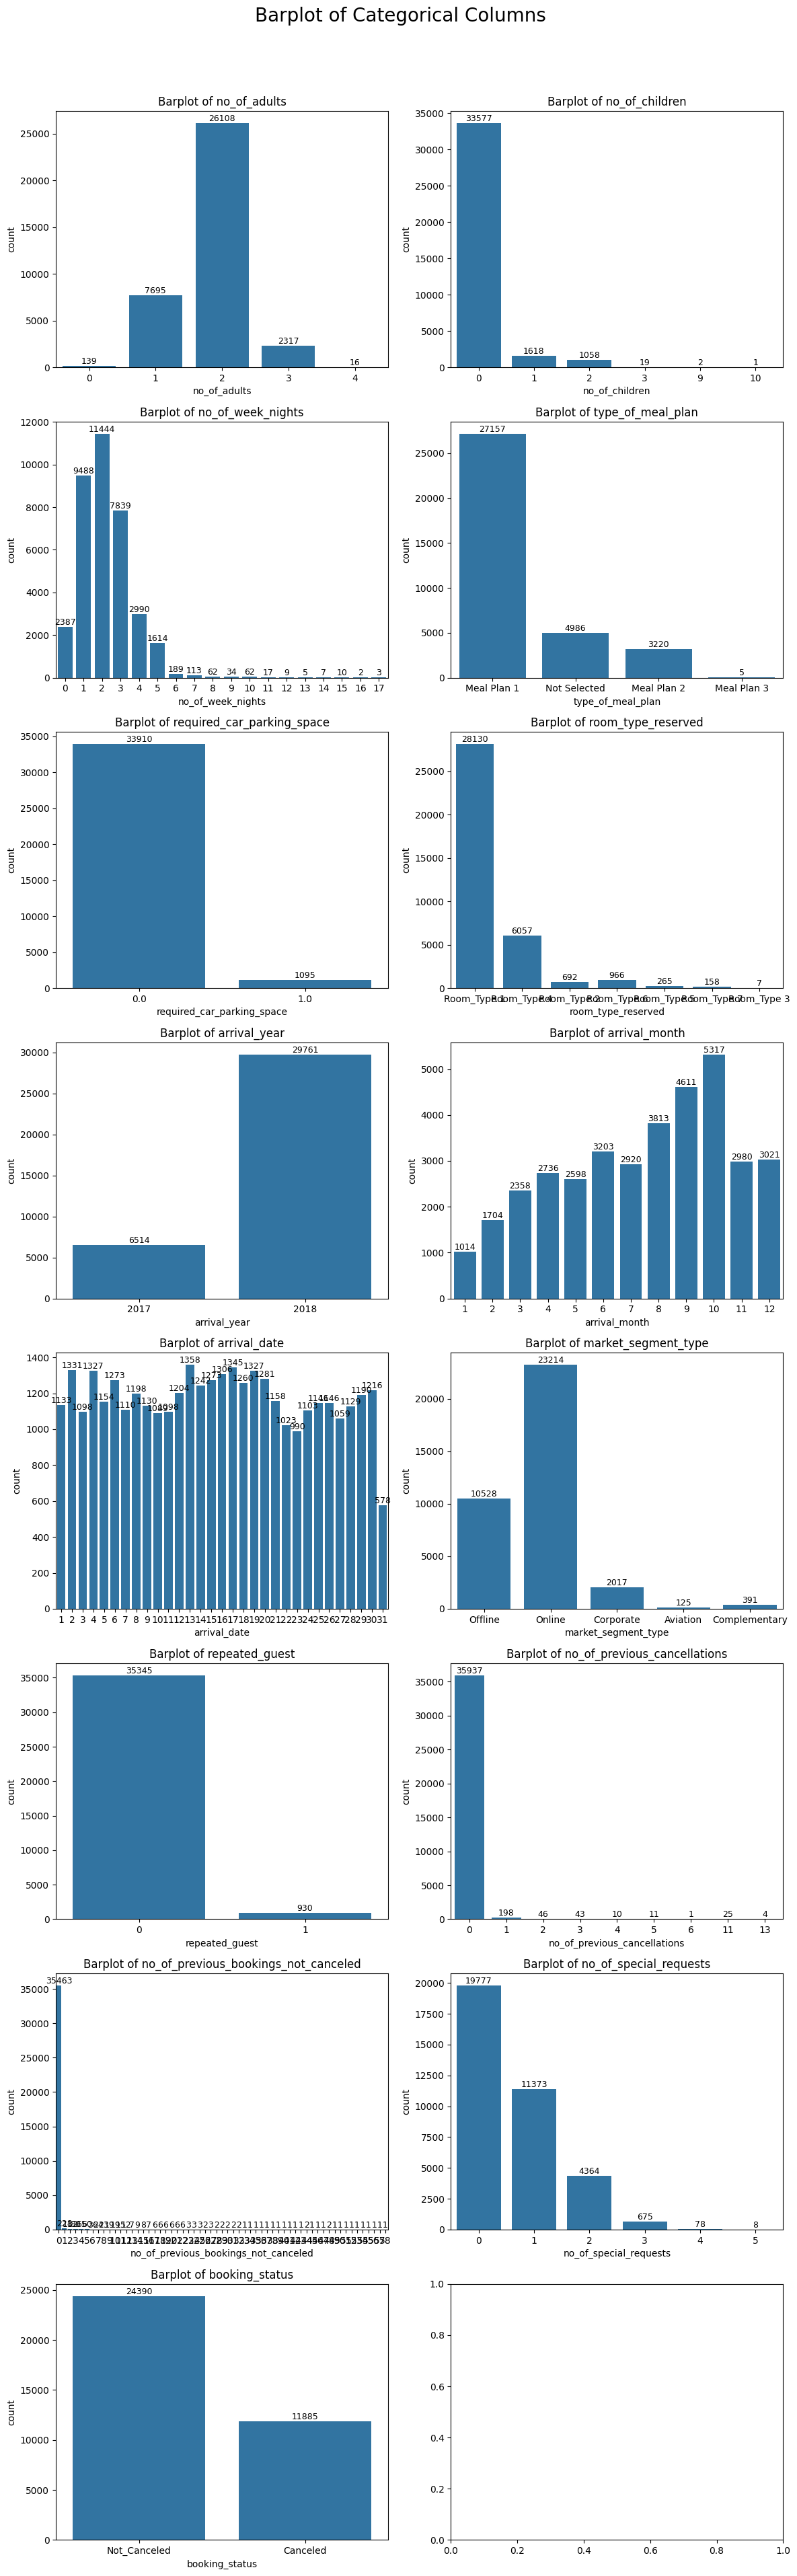

In [14]:
cat_plot(data)

## Data Cleaning

### Drop the missing values

In [15]:
data = data.dropna()

## Data Preprocessing

In [16]:
data = pd.get_dummies(data, columns=['type_of_meal_plan', 'room_type_reserved', "market_segment_type"])
data.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,...,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Aviation,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
0,INN00001,2,0,1,2,0.0,224,2017,10,2,...,False,False,False,False,False,False,False,False,True,False
1,INN00002,2,0,2,3,0.0,5,2018,11,6,...,False,False,False,False,False,False,False,False,False,True
2,INN00003,1,0,2,1,0.0,1,2018,2,28,...,False,False,False,False,False,False,False,False,False,True
3,INN00004,2,0,0,2,0.0,211,2018,5,20,...,False,False,False,False,False,False,False,False,False,True
4,INN00005,2,0,1,1,0.0,48,2018,4,11,...,False,False,False,False,False,False,False,False,False,True


In [17]:
data['arrival_year'] = data['arrival_year'].replace({2017: 0, 2018: 1})
data["booking_status"] = data["booking_status"].replace({'Canceled': 1, 'Not_Canceled': 0})

C:\Users\Austin\AppData\Local\Temp\ipykernel_31720\2125496566.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["booking_status"] = data["booking_status"].replace({'Canceled': 1, 'Not_Canceled': 0})


In [18]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [19]:
scaler = RobustScaler()
train_data[num_cols] = scaler.fit_transform(train_data[num_cols])
test_data[num_cols] = scaler.transform(test_data[num_cols])

In [20]:
x_train = train_data.drop(columns=["Booking_ID", "booking_status"])
y_train = train_data["booking_status"]

x_test = test_data.drop(columns=["Booking_ID", "booking_status"])
y_test = test_data["booking_status"]

## Model

In [21]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_models(y_test, rf_pred, xgb_pred):
    rf_accuracy = accuracy_score(y_test, rf_pred)
    xgb_accuracy = accuracy_score(y_test, xgb_pred)

    rf_precision = precision_score(y_test, rf_pred, average='weighted')
    xgb_precision = precision_score(y_test, xgb_pred, average='weighted')

    rf_recall = recall_score(y_test, rf_pred, average='weighted')
    xgb_recall = recall_score(y_test, xgb_pred, average='weighted')

    rf_f1 = f1_score(y_test, rf_pred, average='weighted')
    xgb_f1 = f1_score(y_test, xgb_pred, average='weighted')

    print("=== Random Forest Metrics ===")
    print(f"Accuracy : {rf_accuracy:.4f}")
    print(f"Precision: {rf_precision:.4f}")
    print(f"Recall   : {rf_recall:.4f}")
    print(f"F1-score : {rf_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, rf_pred))

    print("\n=== XGBoost Metrics ===")
    print(f"Accuracy : {xgb_accuracy:.4f}")
    print(f"Precision: {xgb_precision:.4f}")
    print(f"Recall   : {xgb_recall:.4f}")
    print(f"F1-score : {xgb_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, xgb_pred))


In [24]:
rf_pred = rf_model.predict(x_test)
xgb_pred = xgb_model.predict(x_test)

evaluate_models(y_test, rf_pred, xgb_pred)

=== Random Forest Metrics ===
Accuracy : 0.9023
Precision: 0.9017
Recall   : 0.9023
F1-score : 0.9009

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4415
           1       0.89      0.80      0.84      2107

    accuracy                           0.90      6522
   macro avg       0.90      0.88      0.89      6522
weighted avg       0.90      0.90      0.90      6522


=== XGBoost Metrics ===
Accuracy : 0.8939
Precision: 0.8928
Recall   : 0.8939
F1-score : 0.8927

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      4415
           1       0.86      0.80      0.83      2107

    accuracy                           0.89      6522
   macro avg       0.89      0.87      0.88      6522
weighted avg       0.89      0.89      0.89      6522



In [25]:
rf_model = RandomForestClassifier(random_state=42)

rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 3, 5, 7, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(
    rf_model, rf_params,
    n_iter=50, cv=10, verbose=1,
    random_state=42, n_jobs=-1
)

In [26]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

xgb_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 3, 5, 7, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_lambda': [1, 1.5, 2]
}

xgb_search = RandomizedSearchCV(
    xgb_model, xgb_params,
    n_iter=50, cv=10, verbose=1,
    random_state=42, n_jobs=-1
)

In [27]:
# Untuk Random Forest
rf_search.fit(x_train, y_train)
print("Best RF Params:", rf_search.best_params_)
print("Best RF Score:", rf_search.best_score_)

# Untuk XGBoost
xgb_search.fit(x_train, y_train)
print("Best XGB Params:", xgb_search.best_params_)
print("Best XGB Score:", xgb_search.best_score_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best RF Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Best RF Score: 0.8995210214994346
Fitting 10 folds for each of 50 candidates, totalling 500 fits


c:\Users\Austin\anaconda3\envs\UTSMD\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:28:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Params: {'subsample': 1.0, 'reg_lambda': 1.5, 'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
Best XGB Score: 0.8990993158415772


In [28]:
rf_pred = rf_search.predict(x_test)
xgb_pred = xgb_search.predict(x_test)

evaluate_models(y_test, rf_pred, xgb_pred)

=== Random Forest Metrics ===
Accuracy : 0.9033
Precision: 0.9026
Recall   : 0.9033
F1-score : 0.9018

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4415
           1       0.89      0.80      0.84      2107

    accuracy                           0.90      6522
   macro avg       0.90      0.88      0.89      6522
weighted avg       0.90      0.90      0.90      6522


=== XGBoost Metrics ===
Accuracy : 0.9034
Precision: 0.9026
Recall   : 0.9034
F1-score : 0.9022

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4415
           1       0.88      0.81      0.84      2107

    accuracy                           0.90      6522
   macro avg       0.90      0.88      0.89      6522
weighted avg       0.90      0.90      0.90      6522



In [32]:
import pickle

# Save model
with open('Model/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_search, f)

with open("Model/model_features.pkl", "wb") as f:
    pickle.dump(x_train.columns.tolist(), f)

with open("Model/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)